In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import missingno as msno

from keras.layers import Input, Dense, concatenate, Embedding, LSTM, Conv1D, Flatten, MaxPooling1D
from keras.layers import Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1, l2

import time

import matplotlib.pyplot as plt
%matplotlib inline

/Users/akshay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
df = pd.read_csv('job_skills.csv')
df.head(3)

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...


In [5]:
df.dropna(inplace=True)

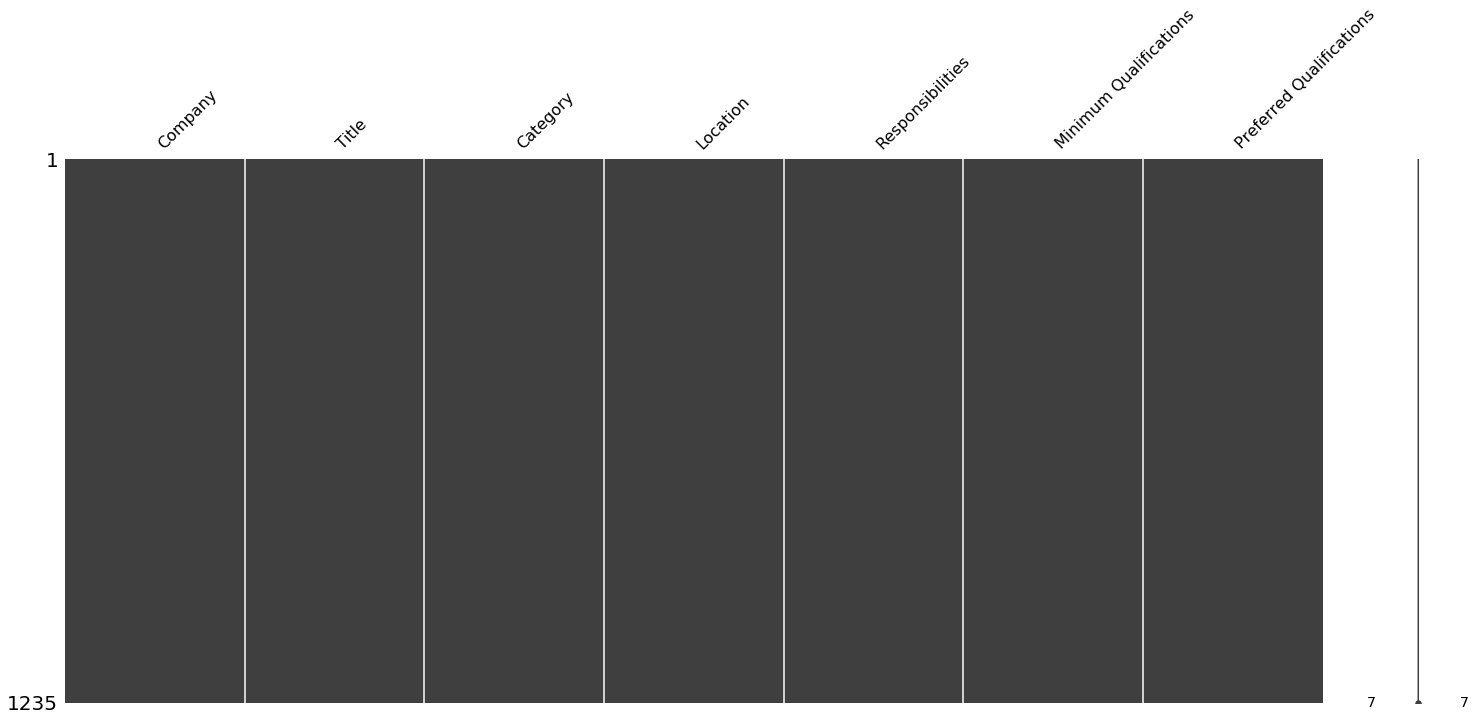

In [6]:
msno.matrix(df)

In [7]:
def combine(i):
    return ' '.join(df.iloc[i,-3:]).replace("\n","")

In [8]:
X = [combine(i) for i in range(df.shape[0])]
y = df['Category']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify=y, random_state=42)
print([len(i) for i in [X_train, X_test, y_train, y_test]])

[1049, 186, 1049, 186]


# Functional model with Multi-inputs

In [10]:
cnt = CountVectorizer(stop_words=None)
cnt.fit(X_train)
len(cnt.vocabulary_)

5598

In [11]:
vocab_size = 5598

In [12]:
lbl = LabelEncoder()
y_train_lbl = lbl.fit_transform(y_train)

(1049, 300)

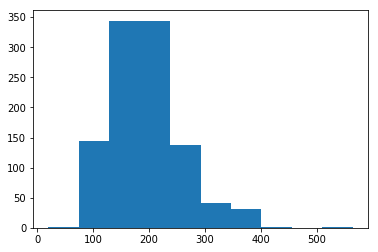

In [13]:
t = Tokenizer(num_words=vocab_size)
t.fit_on_texts(X_train)
seq = t.texts_to_sequences(X_train)
plt.hist([len(i) for i in seq])
X_train_pad = pad_sequences(seq, maxlen=300, truncating='post', padding='post')
X_train_pad.shape

In [14]:
out_dims = len(np.unique(y_train))
inp_dims = X_train_pad.shape[1]

In [15]:
inp = Input((inp_dims,))
embed_out = Embedding(vocab_size, 64, input_length=inp_dims)(inp)

x = Conv1D(filters=32, kernel_size=5, activation='relu')(embed_out)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(out_dims, activation='softmax')(x)

model = Model(inp, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 64)           358272    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 32)           10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 146, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 73, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2336)              0         
__________

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(X_train_pad, y_train_lbl,      
          epochs=100, 
          batch_size=128, 
          validation_split=0.2, 
          verbose=0)

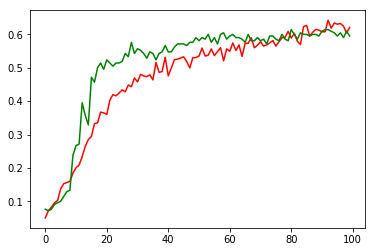

In [17]:
plt.plot(model.history.history.get('acc'),'r')
plt.plot(model.history.history.get('val_acc'),'g')

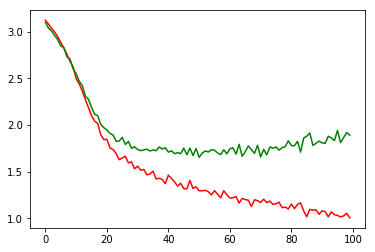

In [18]:
plt.plot(model.history.history.get('loss'),'r')
plt.plot(model.history.history.get('val_loss'),'g')

# Check embeddings

In [20]:
weights = model.layers[1]

In [21]:
embedding_weights = weights.get_weights()[0]

In [22]:
embedding_weights.shape

(5598, 64)

In [23]:
t.index_word

{1: 'and',
 2: 'to',
 3: 'in',
 4: 'experience',
 5: 'with',
 6: 'of',
 7: 'the',
 8: 'or',
 9: 'a',
 10: 'ability',
 11: 'business',
 12: 'for',
 13: 'as',
 14: 'skills',
 15: 'management',
 16: 'work',
 17: 'degree',
 18: 'technical',
 19: 'on',
 20: 'google',
 21: 'product',
 22: 'equivalent',
 23: 'teams',
 24: 'sales',
 25: 'practical',
 26: 'data',
 27: 'cloud',
 28: 'team',
 29: 'years',
 30: 'customer',
 31: 'bs',
 32: 'working',
 33: 'ba',
 34: 'develop',
 35: 'marketing',
 36: 'design',
 37: 'partners',
 38: 'manage',
 39: 'an',
 40: 'related',
 41: 'engineering',
 42: 'including',
 43: 'strategic',
 44: 'development',
 45: 'partner',
 46: 'drive',
 47: 'communication',
 48: 'environment',
 49: 'demonstrated',
 50: 'cross',
 51: 'that',
 52: 'across',
 53: 'technology',
 54: 'support',
 55: 'solutions',
 56: 'relationships',
 57: 'excellent',
 58: 'field',
 59: 'functional',
 60: 'our',
 61: 'projects',
 62: 'program',
 63: 'strong',
 64: 'analytical',
 65: 'be',
 66: 'produc

In [24]:
embedding_weights[27+1]

array([ 0.05333141,  0.06004441,  0.01493547, -0.0418154 ,  0.02755466,
        0.07088573, -0.04709975,  0.02263932, -0.05884545, -0.04626363,
        0.02329914, -0.05508772,  0.01368635,  0.04025827,  0.04878268,
        0.01286098,  0.01884055,  0.0604221 ,  0.0615286 ,  0.05634351,
       -0.0025716 , -0.09998442, -0.09037267, -0.01000194, -0.05093603,
        0.04857781, -0.04111328, -0.03811172,  0.0187408 ,  0.08112483,
        0.06489071, -0.03519522, -0.01450824,  0.05735616, -0.06884374,
        0.04571062, -0.03225119,  0.05518281,  0.00606439, -0.00272975,
       -0.01231454, -0.04477984, -0.04460078,  0.02354236, -0.04599449,
        0.04754445,  0.04848186, -0.03112249,  0.0939311 ,  0.03452414,
        0.04246847,  0.0397692 ,  0.06785726, -0.08868758,  0.0311173 ,
        0.05329762, -0.00420148, -0.03494041, -0.06642228,  0.05978181,
        0.05387303, -0.06261639, -0.06676813,  0.04333443], dtype=float32)

In [25]:
dots = np.dot(embedding_weights, embedding_weights.T)
dots.shape

(5598, 5598)

In [26]:
def get_nearest_words(word,num = 10):
    pos = t.word_index.get(word)
    row = dots[pos-1]
    sorted_indexes = np.argsort(row)
    tops = sorted_indexes[-num:]
    bottoms = sorted_indexes[:num]
    
    
    top_words = [t.index_word.get(i) for i in tops]
    bottom_words = [t.index_word.get(i) for i in bottoms]
    
    return top_words, bottom_words

In [27]:
t.index_word

{1: 'and',
 2: 'to',
 3: 'in',
 4: 'experience',
 5: 'with',
 6: 'of',
 7: 'the',
 8: 'or',
 9: 'a',
 10: 'ability',
 11: 'business',
 12: 'for',
 13: 'as',
 14: 'skills',
 15: 'management',
 16: 'work',
 17: 'degree',
 18: 'technical',
 19: 'on',
 20: 'google',
 21: 'product',
 22: 'equivalent',
 23: 'teams',
 24: 'sales',
 25: 'practical',
 26: 'data',
 27: 'cloud',
 28: 'team',
 29: 'years',
 30: 'customer',
 31: 'bs',
 32: 'working',
 33: 'ba',
 34: 'develop',
 35: 'marketing',
 36: 'design',
 37: 'partners',
 38: 'manage',
 39: 'an',
 40: 'related',
 41: 'engineering',
 42: 'including',
 43: 'strategic',
 44: 'development',
 45: 'partner',
 46: 'drive',
 47: 'communication',
 48: 'environment',
 49: 'demonstrated',
 50: 'cross',
 51: 'that',
 52: 'across',
 53: 'technology',
 54: 'support',
 55: 'solutions',
 56: 'relationships',
 57: 'excellent',
 58: 'field',
 59: 'functional',
 60: 'our',
 61: 'projects',
 62: 'program',
 63: 'strong',
 64: 'analytical',
 65: 'be',
 66: 'produc

In [28]:
get_nearest_words('google')

(['coherent',
  'message',
  'knack',
  'sensitivities',
  'intersection',
  'korean',
  'steps',
  'request',
  'decisionsoutstanding',
  'on'],
 ['crystalize',
  'can',
  'yield',
  'workforce',
  'document',
  'quota',
  'conflict',
  'implementation',
  'overcome',
  'reaching'])